In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
from os.path import getsize
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import nilearn.image, nilearn.masking
from nilearn import plotting as nplt
import statsmodels.stats.multitest

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
# from PCRegression import PCR
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

import random

In [2]:
# To make plots using Matplotlib, you must first enable IPython's matplotlib mode.
# To do this, run the %matplotlib magic command to enable plotting in the current Notebook.
# This magic takes an optional argument that specifies which Matplotlib backend should be used. 
# Most of the time, in the Notebook, you will want to use the inline backend,
# which will embed plots inside the Notebook:
%matplotlib inline

In [3]:
sigma_1 = 0.682689492137
sigma_2 = 0.954499736104
sigma_3 = 0.997300203937
today = date.today().strftime("%Y%m%d")

In [4]:
cm = LinearSegmentedColormap.from_list('GA', [(1, 1, 1), (19/255, 24/255, 38/255)], N=1)

In [5]:
root_dir = '/Volumes/T7SSD1/GA'
# git_dir = '/Users/clmn/Desktop/GitHub/labs'
git_dir = '../..'
script_dir = '.'

In [6]:
id_list = ['GA', 'GB']
nn_list = ['01', '02', '05', '07', '08', '11', '12', '13', '14', '15',
           '18', '19', '20', '21', '23', '26', '27', '28', '29', '30',
           '31', '32', '33', '34', '35', '36', '37', '38', '42', '44']
run_list = ['r01', 'r02', 'r03', 'r04', 'r05', 'r06']

In [7]:
fMRI_dir = root_dir + '/fMRI_data'
preproc_dir = fMRI_dir + '/preproc_data'
stat_dir = fMRI_dir + '/stats'
roi_dir = fMRI_dir + '/roi'
loc_dir = roi_dir + '/localizer'
dmn_dir = roi_dir + '/DMN'
# roi_full_dir = roi_dir + '/full'                # tlrc
# roi_caudate_dir = roi_dir + '/GA_caudate_roi'   # orig
# roi_split_dir = roi_dir + '/split_roi'          # orig
# roi_caudate_fin_dir = roi_caudate_dir + '/slicer_2/tlrc_resam_fullmask' # MNI
data_dir = preproc_dir

In [8]:
def fast_masking(img, roi):
    # img : nifti image
    # roi : nifti image
    # output : (times, voxels)-dimension fdata array
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)
    
    if img_data.shape[:3] != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))
        
    return img_data[roi_mask, :].T    # the shape is (times, voxels) which is to cross-validate for times(=runs)

In [9]:
## LDA analysis
model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

In [10]:
def cross_valid(estimator, ROI_imgs, pickle_name):
    # estimator : model
    # ROI_imgs : nifti image
    # pickle_name : string
    # output : A leave-one-run-out cross-validation (LORO-CV) result and save pickle file
    ## set the parameters
    nrun = 3
    ntpr = 96 # a number of trials per run
    cv = GroupKFold(nrun)
    y = [j for i in range(nrun) for j in target_pos] # answer
    group = [i for i in range(nrun) for j in target_pos] # run number
    
    ## cross-validation
    pkl = {}
    for ii in id_list:
        for nn in nn_list:
            subj = ii + nn
            for roi, roi_img in ROI_imgs.items():
                for i, pp in enumerate(['practiced','unpracticed']):
                    X = np.array([fast_masking(img=data[subj,rr],roi=roi_img) for rr in run_list[i*3:(i+1)*3]])
                    X = X.reshape([nrun*ntpr,X.shape[-1]],order='C') # X.shape = (ntrial,nvoxle)
                    score = cross_validate(
                        estimator=estimator
                        , X=X, y=y, groups=group
                        , cv=cv, return_estimator=True, return_train_score=True)
                    pkl[subj, roi, pp] = np.mean(score['test_score'])
                print(subj, roi, end='\r')
                
    ## Save as .pickle
    with open(today+'_%s.pkl'%pickle_name,"wb") as fw:
        pickle.dump(pkl, fw)
        
    return pkl

In [11]:
def show_pkl_list(word):
    pkl_list = glob('*%s*.pkl'%word)
    df = pd.DataFrame({'name':pkl_list})
    group = ['' for i in pkl_list]

    ## check the identity
    idty = ['a','b','c','d','e','f','g','h','i','j','k','l','m'
            ,'n','o','p','q','r','s','t','u','v','w','x','y','z'
            ,'A','B','C','D','E','F','G','H','I','J','K','L','M'
            ,'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    gg = 0
    for n,p in enumerate(pkl_list):
        ## assign a pkl a name of the group
        ## check that the pkl has a group
        if len(group[n])!=0:
            continue
        group[n] = idty[gg]
        ## check the similarity
        with open(p,"rb") as fp:
            pkl_n = pickle.load(file=fp)
        for m,q in enumerate(pkl_list[(n+1):]):
            if len(group[m+n+1])!=0:
                continue
            if getsize(join(script_dir,p))!=getsize(join(script_dir,q)):
                continue
            ## Comparison sorting
            with open(q,"rb") as fq:
                pkl_m = pickle.load(file=fq)
#             if pkl_n==pkl_m:
#                 group[m+n] = idty[gg]
            all_same = True
            for key in pkl_n.keys():
                if not np.array_equal(pkl_n[key], pkl_m[key]):
                    all_same = False
                    break
            if all_same:
                group[m+n+1] = idty[gg]
        gg += 1
    df['identity']=group
    
    return df

In [12]:
def make_dataframe(roi_list, pkl):
    wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

    for ii in id_list:
        ss = 'Early' if ii == 'GA' else 'Late'
        for nn in nn_list:
            subj = ii + nn
            for roi_name in roi_list:
                for pp in ['unpracticed', 'practiced']:
                    wit_df = wit_df.append(
                        {'subj': subj
                         ,'roi_name': roi_name
                         ,'Mapping': pp
                         ,'Mean Accuracy': np.mean(pkl[subj, roi_name, pp])
                         ,'Stage': ss}
                        , ignore_index=True)
    return wit_df

In [13]:
def wit_df_t_test(wit_df, roi_list, column_name, criteria):
    gg = wit_df[column_name].unique()
    key = list(criteria.keys())[0]
    value = list(criteria.values())[0]

    pvals, tvals = [], []

    for roi_name in roi_list:
        sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df[key] == value)]

        mean_accs = [sub_df[sub_df[column_name] == i]['Mean Accuracy'] for i in gg]

        res = scipy.stats.ttest_rel(mean_accs[0], mean_accs[1])
        pvals.append(res.pvalue)
        tvals.append(res.statistic)

    res = statsmodels.stats.multitest.fdrcorrection(pvals)

    for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_list, pvals, tvals):
        if uncorrected_p < 0.05:
            print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

In [14]:
# helper function for calc mean measure
def calc_scores_pearson(from_roi, to_roi, *, mu_data, mapping, stage, subj_mean=False):
    f, t = sorted((from_roi, to_roi))

    measures = []
    
    ii = 'GA' if stage == 'Early' else 'GB'
        
    rr = run_list[:3] if mapping == 'practiced' else run_list[3:]

    for nn in nn_list:
        subj = ii + nn
        print(subj, '%s -> %s'%(from_roi,to_roi), end='\r')
        res = []
        for r in rr:
            coef, _ = scipy.stats.pearsonr(mu_data[subj, f, mapping, r], mu_data[subj, t, mapping, r])
            res.append(coef)
        measures.append(np.mean(res))
    if subj_mean is True:
        return np.mean(measures)
    else:
        ## Average of each subject
        return np.array(measures)

In [15]:
def scores_pearson(mu_data, rois, pickle_name):
    scores = {}

    for i, from_roi in enumerate(rois):
        for to_roi in rois[(i+1):]:
            for pp in ['practiced','unpracticed']:
                for ss in ['Early','Late']:
                    scores[ss, pp, (*sorted((from_roi, to_roi)),)] = calc_scores_pearson(from_roi, to_roi, mu_data=mu_data, mapping=pp, stage=ss)

    ## Save as .pickle
    with open(today+'_%s.pkl'%pickle_name,"wb") as fw:
        pickle.dump(scores, fw)

# GLM: overall fMRI activites associated with the 4 targets

## Loading $\beta$s

# MVPA
#### Multi-voxel pattern analysis (MVPA) is gaining increasing interest in the neuroimaging community because it allows to detect differences between conditions with higher sensitivity than conventional univariate analysis by focusing on the analysis and comparison of distributed patterns of activity. In such a multivariate approach, data from individual voxels within a region are jointly analyzed. Furthermore, MVPA is often presented in the context of "brain reading" applications reporting that specific mental states or representational content can be decoded from fMRI activity patterns after performing a "training" or "learning phase. In this context, MVPA tools are often referred to as classifiers or, more generally, learning machines. The latter names stress that many MVPA tools originate from a field called machine learning, a branch of artificial intelligence.

In [16]:
## background image
img_bg = join(roi_dir,'mni152_2009bet.nii.gz')

## Loading $\beta$s

In [17]:
## load betas
data = {}

for ii in id_list:
    for nn in nn_list:
        subj = ii + nn
        for run in run_list:
            data[subj, run] = nilearn.image.load_img(join(data_dir,nn,'betasLSS.%s.%s.nii.gz'%(subj,run)))
        print(subj, end='\r')

## indexing
for key, value in data.items():
    data[key] = nilearn.image.index_img(value, np.arange(1, 97))

## labeling with target position
target_pos = []

with open(join(root_dir,'targetID.txt')) as file:
    for line in file:
        target_pos.append(int(line.strip()))
        
target_pos = target_pos[1:97]
target_path = list(range(1,13))*8

## Movement-related ROIs from localizer

In [16]:
roi_path = sorted(glob(loc_dir + '/n200_*.nii'))
roi_imgs = {}

for path in roi_path:
    roi_imgs[path.split('/')[-1].replace('_mask.nii', '')] = (nilearn.image.load_img(path))
    
roi_names = sorted(roi_imgs.keys())
roi_names

['n200_c1-1_L_M1',
 'n200_c1-2_L_S1',
 'n200_c1_L_Postcentral',
 'n200_c1_R_SPL',
 'n200_c2_R_CerebellumIV-V',
 'n200_c2_R_MFG',
 'n200_c3_R_MTG',
 'n200_c3_R_Postcentral',
 'n200_c4_L_IFG',
 'n200_c4_L_Putamen',
 'n200_c5_L_SPL',
 'n200_c5_R_SMA',
 'n200_c6_R_CerebellumVIIIb',
 'n200_c6_R_MFG',
 'n200_c7_L_Thalamus',
 'n200_c7_R_MFG2',
 'n200_c8_R_IFG',
 'n200_c9_L_MTG']

### Calculation and saving the results

In [18]:
results = cross_valid(estimator=model, ROI_imgs=roi_imgs, pickle_name='dec-acc_move-rel')

NameError: name 'target_pos' is not defined

### Loading the above result .pkl

In [17]:
dpkl = show_pkl_list(word='dec-acc_move-rel')
dpkl

name identity
0  20210113_dec-acc_move-rel.pkl        a
1  20210112_dec-acc_move-rel.pkl        a
2  20210106_dec-acc_move-rel.pkl        a

In [18]:
## Load pickle
with open(dpkl.loc[0,'name'],"rb") as fr:
    results = pickle.load(file=fr)
# print(results)

### Summarizing the results to DataFrame

In [19]:
wit_df = make_dataframe(roi_list=roi_names, pkl=results)
wit_df

subj               roi_name      Mapping  Mean Accuracy  Stage
0     GA01         n200_c1-1_L_M1  unpracticed       0.315972  Early
1     GA01         n200_c1-1_L_M1    practiced       0.368056  Early
2     GA01         n200_c1-2_L_S1  unpracticed       0.420139  Early
3     GA01         n200_c1-2_L_S1    practiced       0.357639  Early
4     GA01  n200_c1_L_Postcentral  unpracticed       0.413194  Early
...    ...                    ...          ...            ...    ...
2155  GB44         n200_c7_R_MFG2    practiced       0.270833   Late
2156  GB44          n200_c8_R_IFG  unpracticed       0.329861   Late
2157  GB44          n200_c8_R_IFG    practiced       0.291667   Late
2158  GB44          n200_c9_L_MTG  unpracticed       0.225694   Late
2159  GB44          n200_c9_L_MTG    practiced       0.225694   Late

[2160 rows x 5 columns]

In [76]:
ROI = 'n200_c1-2_L_S1'
MAP = 'practiced'
tmpA = wit_df[(wit_df.roi_name==ROI)&(wit_df.Mapping==MAP)&(wit_df.Stage=='Early')]['Mean Accuracy']
tmpB = wit_df[(wit_df.roi_name==ROI)&(wit_df.Mapping==MAP)&(wit_df.Stage=='Late')]['Mean Accuracy']
diff = [b-a for a,b in zip(tmpA,tmpB)]

In [79]:
tmpA=[30.02, 29.99, 30.11, 29.97, 30.01, 29.99]
tmpB=[29.89, 29.93, 29.72, 29.98, 30.02, 29.98]

In [86]:
de = np.mean(tmpA)-np.mean(tmpB)

In [87]:
nu = np.sqrt(np.var(tmpA)/5+np.var(tmpB)/5)

In [88]:
de/nu

1.9590058081081436

In [89]:
scipy.stats.ttest_ind(tmpB,tmpA)

Ttest_indResult(statistic=-1.9590058081081436, pvalue=0.07856577385723071)

In [80]:
scipy.stats.ttest_rel(tmpB,tmpA)

Ttest_relResult(statistic=-1.5099668870541376, pvalue=0.191436884336601)

### t-test

In [22]:
wit_df_t_test(wit_df=wit_df, roi_list=roi_names, column_name='Stage', criteria={'Mapping':'practiced'})

       n200_c1-1_L_M1  True 0.00 -3.96 0.000
       n200_c1-2_L_S1  True 0.00 -4.11 0.000
n200_c1_L_Postcentral  True 0.00 -4.57 0.000


In [23]:
wit_df_t_test(wit_df=wit_df, roi_list=roi_names, column_name='Mapping', criteria={'Stage':'Late'})

       n200_c1-1_L_M1 False 0.11 -2.52 0.018
       n200_c1-2_L_S1  True 0.03 -3.15 0.004
n200_c1_L_Postcentral  True 0.03 -3.15 0.004
        n200_c3_R_MTG False 0.21  2.09 0.046


### Drawing figures

In [22]:
sns.set(style="ticks", context='talk')
palette = ['#D9D9D9', '#F23A29']

def draw_lineplot(roi_name, title):
    plt.figure(figsize=(8, 8))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.225, 0.5)
    plt.ylabel('Decoding accuracy')
#     plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)

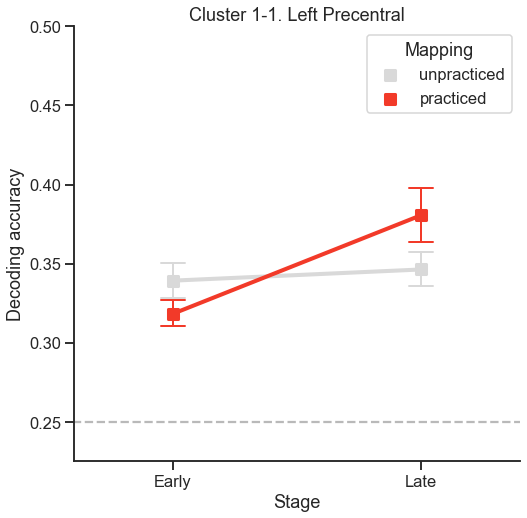

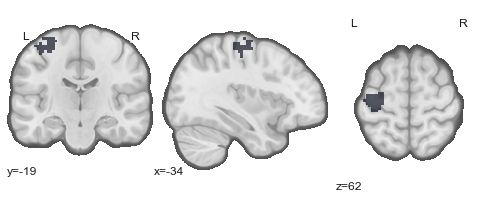

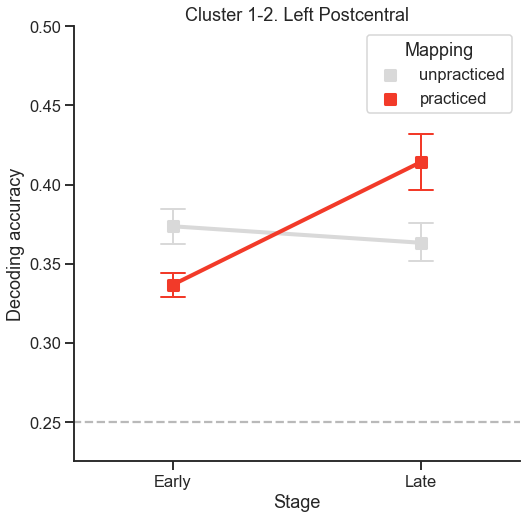

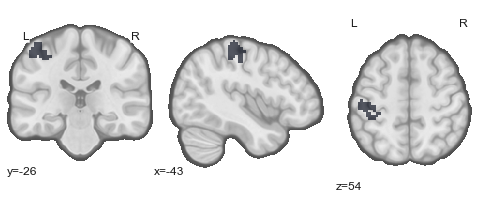

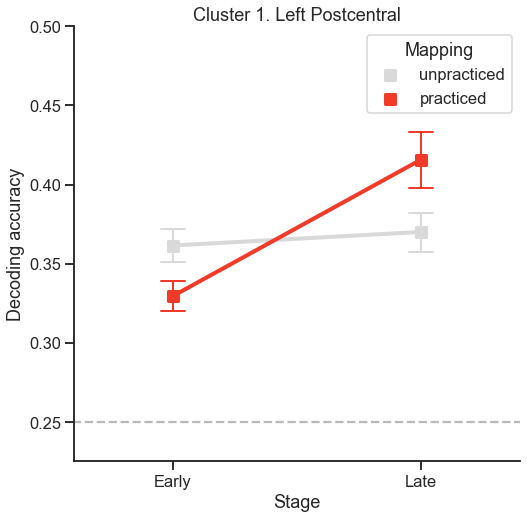

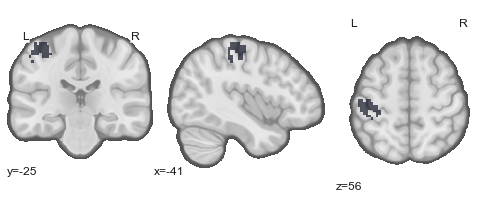

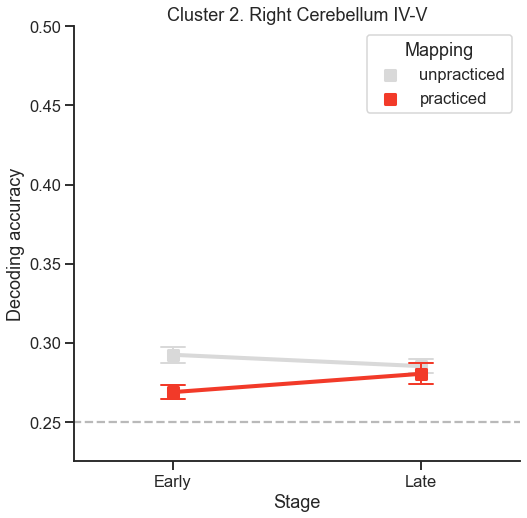

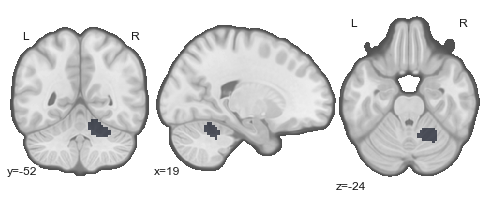

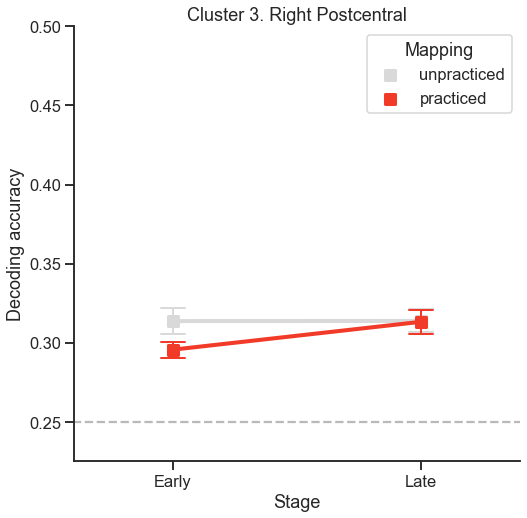

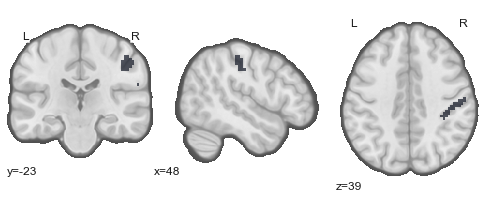

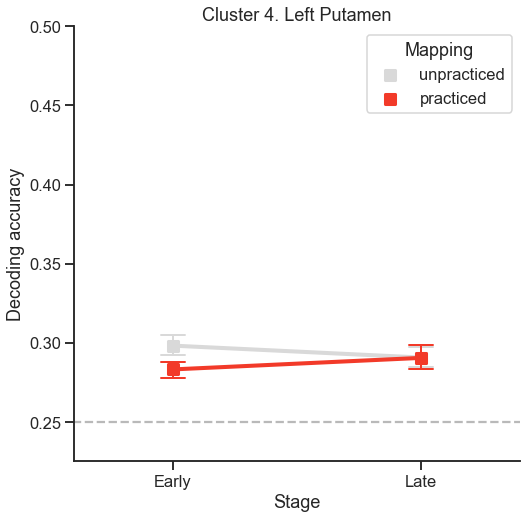

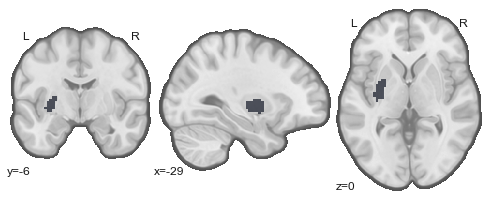

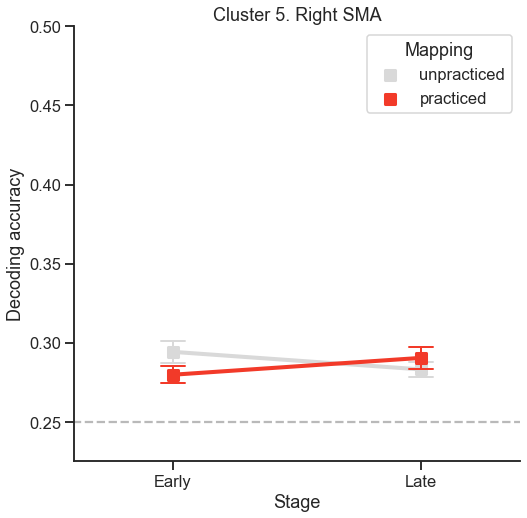

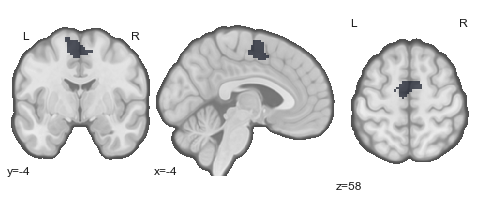

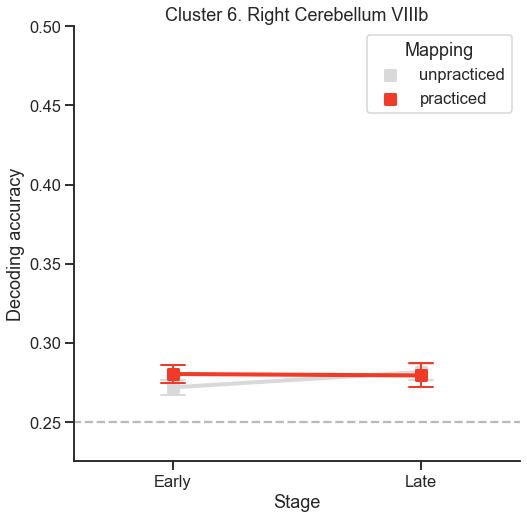

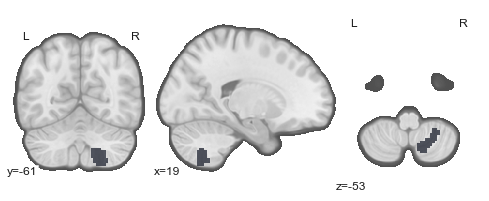

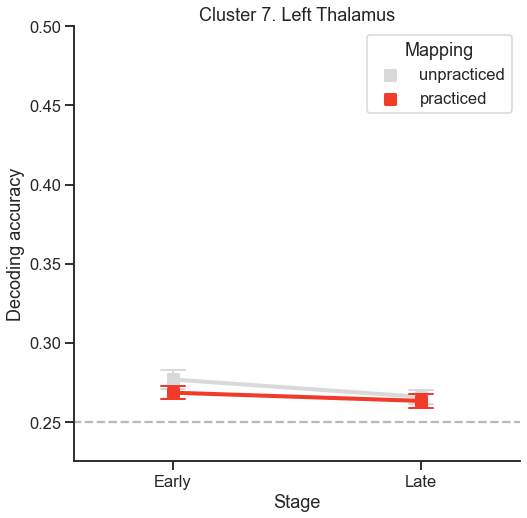

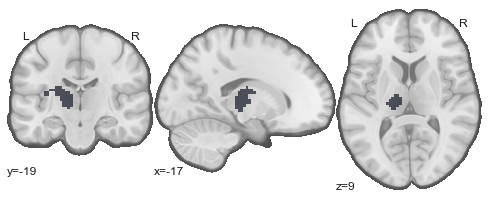

In [29]:
name_list = ['Cluster 1-1. Left Precentral'
             , 'Cluster 1-2. Left Postcentral'
             , 'Cluster 1. Left Postcentral'
             , 'Cluster 2. Right Cerebellum IV-V'
             , 'Cluster 3. Right Postcentral'
             , 'Cluster 4. Left Putamen'
             , 'Cluster 5. Right SMA'
             , 'Cluster 6. Right Cerebellum VIIIb'
             , 'Cluster 7. Left Thalamus']
idx_list = [0, 1, 2, 4, 7, 9, 11, 12, 14]
for i, idx in enumerate(idx_list):
    rname = roi_names[idx]
    draw_lineplot(rname, name_list[i])
    nplt.plot_roi(
        roi_img=roi_imgs[rname], bg_img=img_bg
        , draw_cross=False, black_bg=False, cmap=cm
        , display_mode='ortho'
#         , cut_coords=coord_list[roi]
    )

## Default Mode Network

In [41]:
roi_imgs = {}
roi_names = []

In [42]:
## DMN regions(global)
module_names = ['Core', 'dMsub', 'MTLsub']

for name in module_names:
    DMN_list = glob(join(dmn_dir, name+'.nii'))
    for path in DMN_list:
        fname = path.split('/')[-1].replace('.nii', '')
        roi_imgs[fname] = nilearn.image.load_img(path)
        roi_names.append(fname)

In [43]:
# ## DMN regions(detail)
module_names = ['Core', 'dMsub', 'MTLsub']

for name in module_names:
    DMN_list = glob(join(dmn_dir, name+'_*.nii'))
    for path in DMN_list:
        fname = path.split('/')[-1].replace('.nii', '')
        roi_imgs[fname] = nilearn.image.load_img(path)
        roi_names.append(fname)

In [44]:
roi_names

['Core',
 'dMsub',
 'MTLsub',
 'Core_PCC_l',
 'Core_PCC_r',
 'Core_aMPFC_l',
 'Core_aMPFC_r',
 'dMsub_LTC_l',
 'dMsub_LTC_r',
 'dMsub_TPJ_l',
 'dMsub_TPJ_r',
 'dMsub_TempP_l_temp',
 'dMsub_TempP_r_temp',
 'dMsub_dMPFC',
 'MTLsub_HF_l',
 'MTLsub_HF_r',
 'MTLsub_PHC_l',
 'MTLsub_PHC_r',
 'MTLsub_Rsp_l',
 'MTLsub_Rsp_r',
 'MTLsub_pIPL_l',
 'MTLsub_pIPL_r',
 'MTLsub_vMPFC']

In [28]:
# dmn_roi_img = nilearn.image.math_img(img1=roi_imgs[0], formula='img1 * 0')

# for i, roi_img in enumerate(roi_imgs, 1):
#     dmn_roi_img = nilearn.image.math_img(img1=dmn_roi_img, img2=roi_img, formula='img1 + img2 * %d' % i)
    
# _ = nilearn.plotting.plot_glass_brain(dmn_roi_img)

### ROI markers

In [35]:
## 3D Plots of markers
amPFC = [(-7,52,-2), (7,52,-2)]
PCC = [(-7,-56,25), (7,-56,25)]
coords_core = np.concatenate([amPFC,PCC])
colors_core = ['red' for i in coords_core]

dmPFC = [(1,52,25)]
LTC = [(60,-23,-18), (-60,-23,-18)]
TPJ = [(55,-53,27), (-55,-53,27)]
temporal_pole = [(-47,13,-37), (47,13,-37)]
coords_dmpfc = np.concatenate([dmPFC, LTC, TPJ, temporal_pole])
colors_dmpfc = ['lime' for i in coords_dmpfc]

vmPFC = [(1,25,-18)]
HF = [(23,-21,-26), (-23,-21,-26)]
PHC = [(28,-39,-13), (-28,-39,-13)]
Rsp = [(15,-53,9), (-15,-53,9)]
pIPL = [(44,-74,33), (-44,-74,33)]
coords_mtl = np.concatenate([vmPFC,HF,PHC,Rsp,pIPL])
colors_mtl = ['blue' for i in coords_mtl]

coords_DMN = np.concatenate([coords_core,coords_dmpfc,coords_mtl])
colors_DMN = np.concatenate([colors_core,colors_dmpfc,colors_mtl])

nplt.view_markers(coords_DMN, colors_DMN, marker_size=10)

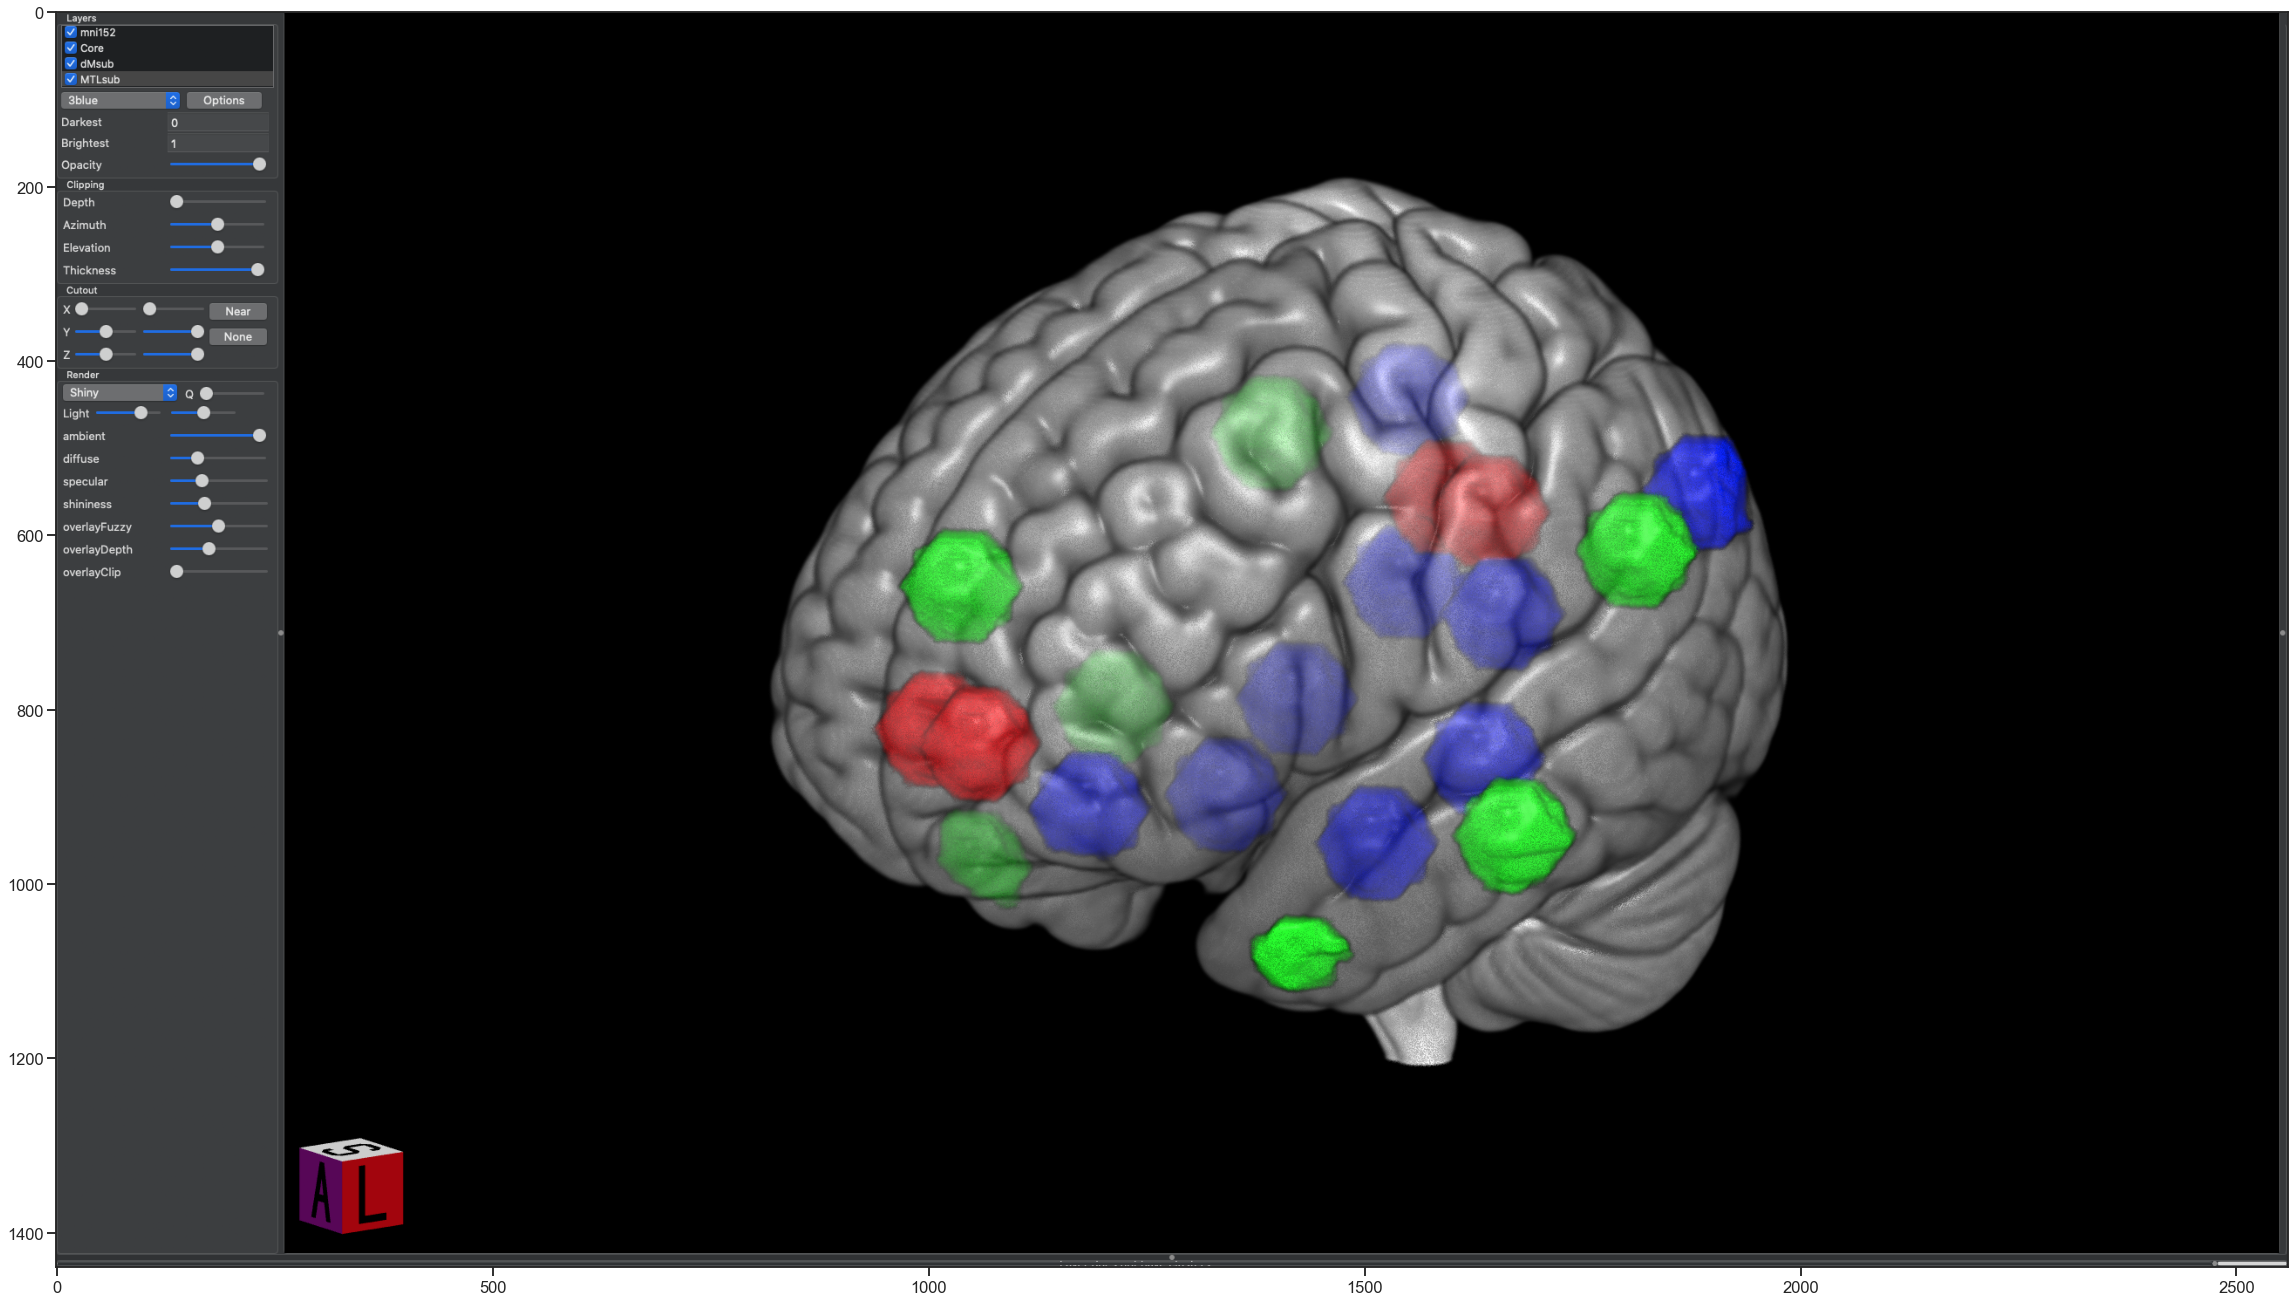

In [30]:
plt.figure(figsize=(40, 32))
plt.imshow(plt.imread(join(git_dir,'GA','3DRender_DMN.png')))

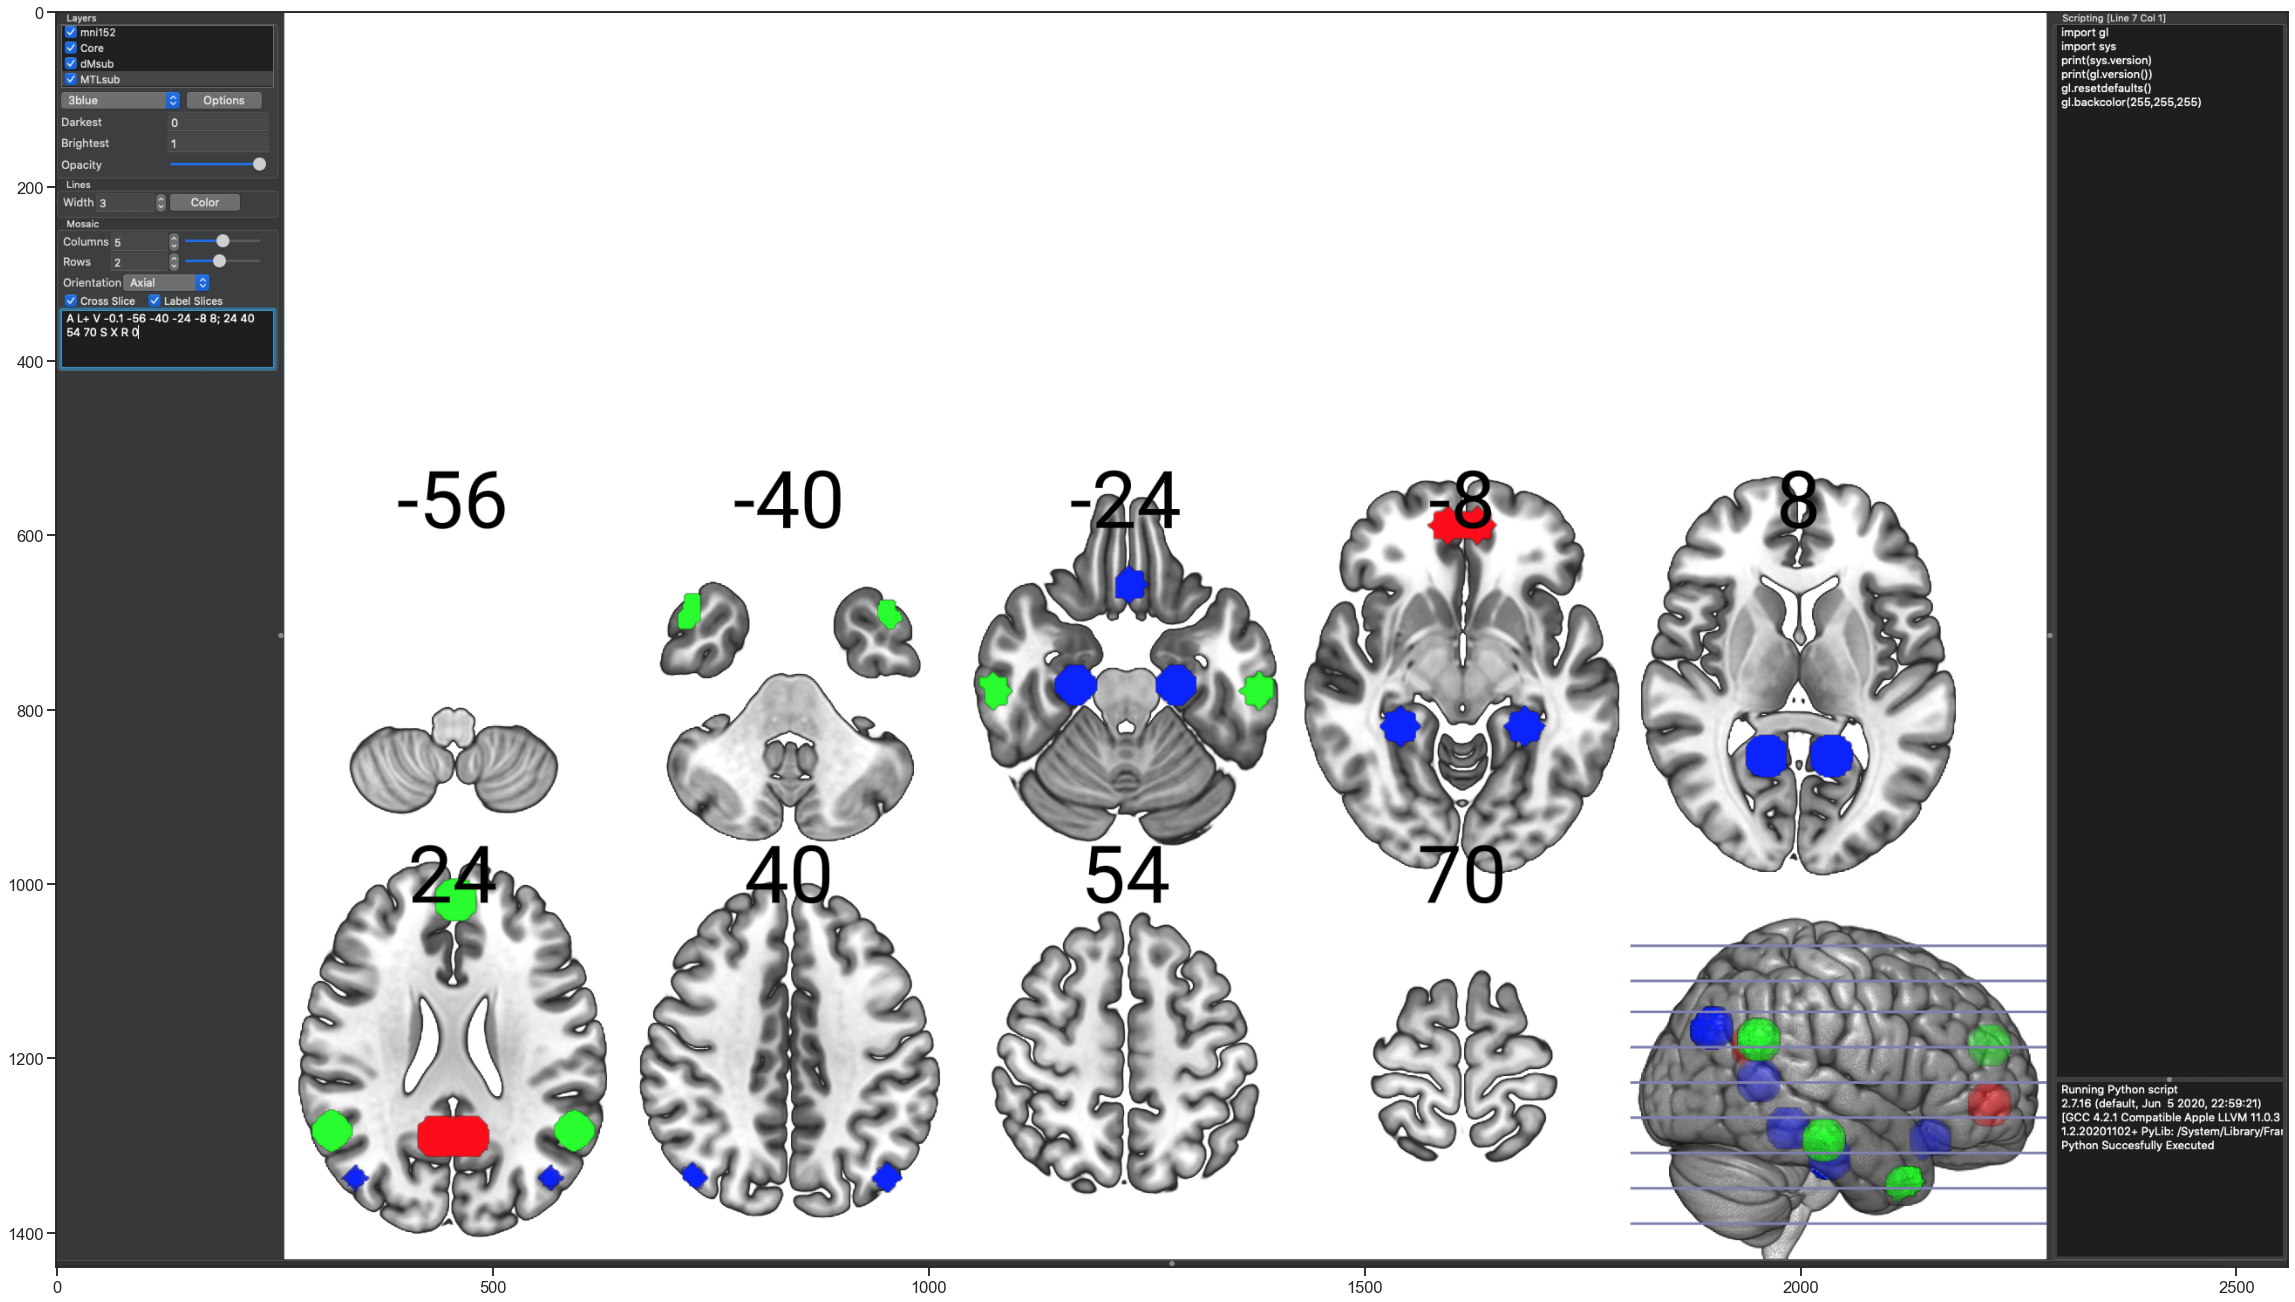

In [31]:
plt.figure(figsize=(40, 32))
plt.imshow(plt.imread(join(git_dir,'GA','3DMarkers_DMN.png')))

### Calculation and saving the results

In [32]:
results = cross_valid(estimator=model, ROI_imgs=roi_imgs, pickle_name='dec-acc_dmn')

### load the pickle

In [38]:
dpkl = show_pkl_list(word='dec-acc_dmn')
dpkl

name identity
0  20210113_dec-acc_dmn.pkl        a
1  20210106_dec-acc_dmn.pkl        a

In [39]:
## Load pickle
with open(dpkl.loc[0,'name'],"rb") as fr:
    results = pickle.load(file=fr)

In [45]:
wit_df = make_dataframe(roi_list=roi_names, pkl=results)
wit_df

subj       roi_name      Mapping  Mean Accuracy  Stage
0     GA01           Core  unpracticed       0.305556  Early
1     GA01           Core    practiced       0.350694  Early
2     GA01          dMsub  unpracticed       0.281250  Early
3     GA01          dMsub    practiced       0.333333  Early
4     GA01         MTLsub  unpracticed       0.295139  Early
...    ...            ...          ...            ...    ...
2755  GB44  MTLsub_pIPL_l    practiced       0.288194   Late
2756  GB44  MTLsub_pIPL_r  unpracticed       0.326389   Late
2757  GB44  MTLsub_pIPL_r    practiced       0.312500   Late
2758  GB44   MTLsub_vMPFC  unpracticed       0.305556   Late
2759  GB44   MTLsub_vMPFC    practiced       0.236111   Late

[2760 rows x 5 columns]

### t test

In [36]:
wit_df_t_test(wit_df=wit_df, roi_list=roi_names, column_name='Stage', criteria={'Mapping':'practiced'})

                 Core False 0.06  3.05 0.005
                dMsub False 0.31  2.14 0.041
   dMsub_TempP_r_temp  True 0.00  4.24 0.000


In [37]:
wit_df_t_test(wit_df=wit_df, roi_list=roi_names, column_name='Mapping', criteria={'Stage':'Late'})

                dMsub False 0.10  3.09 0.004


### figures

In [48]:
sns.set(style="ticks", context='talk')
palette = ['#D9D9D9', '#F23A29']

def draw_lineplot(roi_name, title):
    fig = plt.figure(figsize=(5, 5))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.225, 0.375)
    plt.yticks([0.25, 0.3, 0.35])
    plt.ylabel('Decoding accuracy')
    plt.legend().remove()

    plt.title(title)
    
    return fig

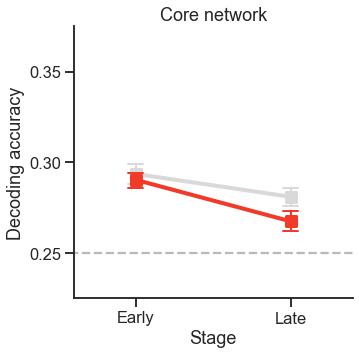

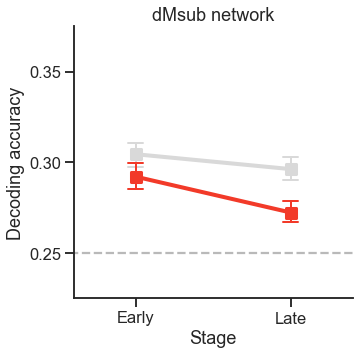

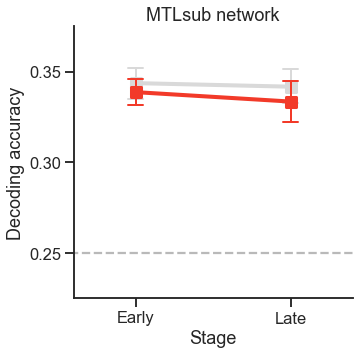

In [49]:
cnt = 0
for roi_name, roi_img in roi_imgs.items():
    ## Core, dmPFC, MTL
    cnt+=1
    if cnt > 3:
        break
    fig = draw_lineplot(roi_name, '%s network'%roi_name)
#     fig.savefig(today+'_dec-acc_%s-module.png'%roi_name, dpi=300, bbox_inches='tight')

In [80]:
# nplt.plot_connectome()

## Visual Area

### Set ROIs

In [45]:
## fan mask
fan_info = pd.read_csv(join(roi_dir,'fan_cluster_net_20200121.csv'))

In [46]:
roi_imgs = {}
roi_names = []

## visual regions
temp = fan_info[(fan_info.yeo_17network == 1) | (fan_info.yeo_17network == 2) | (fan_info.subregion_name == 'V5/MT+')]

for idx in temp.index:
    nn = temp.loc[idx,'label']
    name = temp.loc[idx,'region']
    
    path = join(roi_dir,'fan280','fan.roi.GA.%03d.nii.gz'%nn)
    roi_imgs[name] = nilearn.image.load_img(path)
    
    roi_names.append(name)
roi_names

['FuG_L_3_2',
 'FuG_R_3_2',
 'PhG_L_6_6',
 'PhG_R_6_6',
 'PCun_L_4_3',
 'PCun_R_4_3',
 'MVOcC_L_5_1',
 'MVOcC_R_5_1',
 'MVOcC_L_5_2',
 'MVOcC_R_5_2',
 'MVOcC_L_5_3',
 'MVOcC_R_5_3',
 'MVOcC_L_5_4',
 'MVOcC_R_5_4',
 'MVOcC_L_5_5',
 'MVOcC_R_5_5',
 'LOcC_L_4_1',
 'LOcC_R_4_1',
 'LOcC_L_4_2',
 'LOcC_R_4_2',
 'LOcC_L_4_3',
 'LOcC_R_4_3',
 'LOcC_L_4_4',
 'LOcC_R_4_4',
 'LOcC_L_2_1',
 'LOcC_R_2_1',
 'LOcC_L_2_2']

### Cross-validation

In [22]:
results = cross_valid(estimator=model, ROI_imgs=roi_imgs, pickle_name='dec-acc_visual')

### Load a pkl

In [18]:
dpkl = show_pkl_list(word='dec-acc_visual')
dpkl

name identity
0  20210115_dec-acc_visual.pkl        a
1  20210118_dec-acc_visual.pkl        a
2  20210106_dec-acc_visual.pkl        b

In [19]:
## Load pickle
with open(dpkl.loc[1,'name'],"rb") as fr:
    results = pickle.load(file=fr)

In [20]:
roi_names = sorted(list(set([b for a,b,c in results.keys()])))
roi_names

['FuG_L_3_2',
 'FuG_R_3_2',
 'LOcC_L_2_1',
 'LOcC_L_2_2',
 'LOcC_L_4_1',
 'LOcC_L_4_2',
 'LOcC_L_4_3',
 'LOcC_L_4_4',
 'LOcC_R_2_1',
 'LOcC_R_4_1',
 'LOcC_R_4_2',
 'LOcC_R_4_3',
 'LOcC_R_4_4',
 'MVOcC_L_5_1',
 'MVOcC_L_5_2',
 'MVOcC_L_5_3',
 'MVOcC_L_5_4',
 'MVOcC_L_5_5',
 'MVOcC_R_5_1',
 'MVOcC_R_5_2',
 'MVOcC_R_5_3',
 'MVOcC_R_5_4',
 'MVOcC_R_5_5',
 'PCun_L_4_3',
 'PCun_R_4_3',
 'PhG_L_6_6',
 'PhG_R_6_6']

### Results

In [21]:
wit_df = make_dataframe(roi_list=roi_names, pkl=results)
wit_df

subj    roi_name      Mapping  Mean Accuracy  Stage
0     GA01   FuG_L_3_2  unpracticed       0.375000  Early
1     GA01   FuG_L_3_2    practiced       0.527778  Early
2     GA01   FuG_R_3_2  unpracticed       0.319444  Early
3     GA01   FuG_R_3_2    practiced       0.472222  Early
4     GA01  LOcC_L_2_1  unpracticed       0.430556  Early
...    ...         ...          ...            ...    ...
3235  GB44  PCun_R_4_3    practiced       0.506944   Late
3236  GB44   PhG_L_6_6  unpracticed       0.298611   Late
3237  GB44   PhG_L_6_6    practiced       0.267361   Late
3238  GB44   PhG_R_6_6  unpracticed       0.281250   Late
3239  GB44   PhG_R_6_6    practiced       0.315972   Late

[3240 rows x 5 columns]

In [22]:
wit_df_t_test(wit_df=wit_df, roi_list=roi_names, column_name='Stage', criteria={'Mapping':'practiced'})

           LOcC_L_4_4 False 0.08 -2.44 0.021
           LOcC_R_4_3 False 0.13 -2.07 0.047
          MVOcC_L_5_1 False 0.06 -3.04 0.005
          MVOcC_L_5_2 False 0.06 -2.90 0.007
          MVOcC_L_5_3 False 0.06 -3.28 0.003
          MVOcC_R_5_1 False 0.08 -2.40 0.023
          MVOcC_R_5_2 False 0.06 -2.77 0.010
          MVOcC_R_5_3 False 0.06 -2.73 0.011
          MVOcC_R_5_4 False 0.07 -2.56 0.016
          MVOcC_R_5_5 False 0.11 -2.19 0.037


In [23]:
wit_df_t_test(wit_df=wit_df, roi_list=roi_names, column_name='Mapping', criteria={'Stage':'Late'})

           LOcC_L_4_2 False 0.17  2.55 0.016
          MVOcC_L_5_2 False 0.12 -3.10 0.004
          MVOcC_L_5_3 False 0.17 -2.41 0.022
          MVOcC_R_5_2 False 0.18 -2.11 0.044
          MVOcC_R_5_3 False 0.17 -2.35 0.026
          MVOcC_R_5_4 False 0.18 -2.07 0.048
          MVOcC_R_5_5 False 0.18 -2.08 0.046


In [77]:
sns.set(style="ticks", context='talk')
palette = ['#00A8AA', '#C5C7D2', '#00A8AA', '#C5C7D2']

def draw_lineplot(roi_name, title, ax=None):
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    ax = sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', style='roi_name', data=sub_df
                  , ax=ax, palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
#     plt.plot((-0.5, 2), (.25, .25), 'k--', alpha=0.3)
    ax.set_xlim((-0.4, 1.4))
    ax.set_ylim(.25, .85)
    ax.set_yticks(np.arange(.25,.875,.15))
    ax.set_ylabel('Decoding Accuracy')
    ax.get_legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    ax.set_title(title)
    return ax

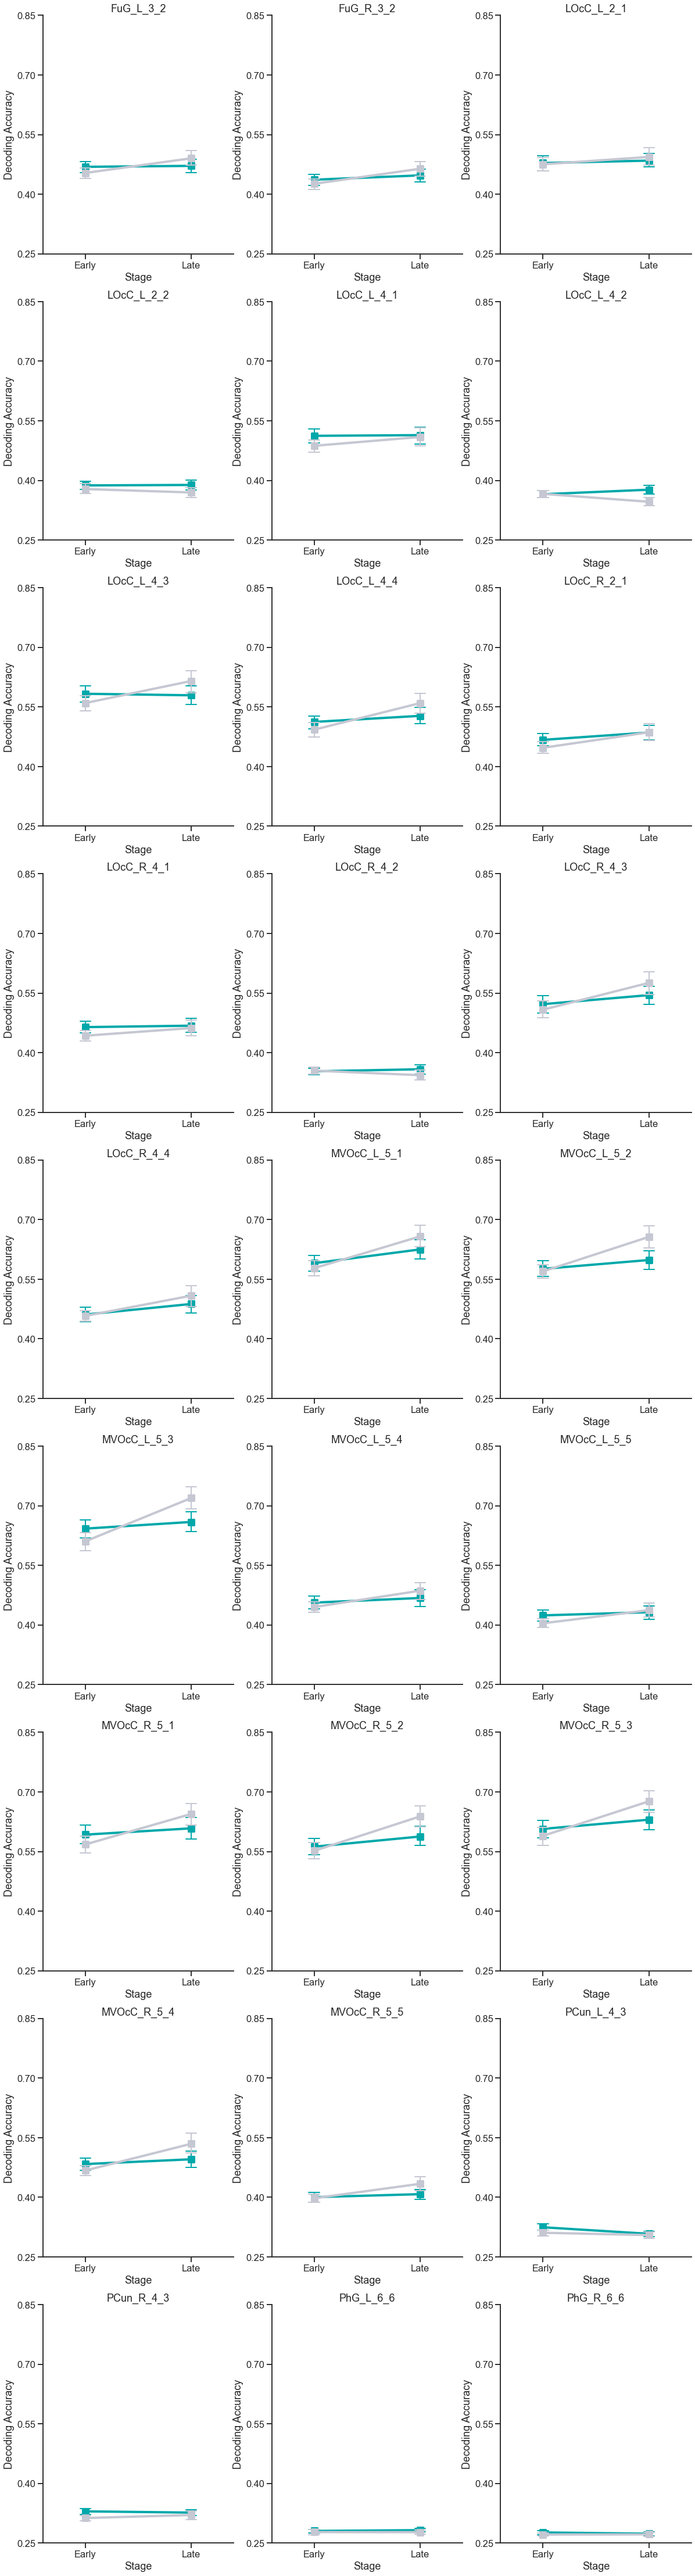

In [81]:
_, axes = plt.subplots(9,3,figsize=(20,80))
axes = np.concatenate(axes)

for i, roi_name in enumerate(roi_names):
    ax = draw_lineplot(roi_name, roi_name, ax=axes[i])

## Correlation between the change in the visual-DMN core integration and improvement in success rate

### Set ROIs

In [23]:
## fan mask
fan_info = pd.read_csv(join(roi_dir,'fan_cluster_net_20200121.csv'))

In [20]:
roi_imgs = {}

## visual regions
temp = fan_info[(fan_info.yeo_17network  == 1) | (fan_info.yeo_17network == 2) | (fan_info.subregion_name == 'V5/MT+')]

for idx in temp.index:
    nn = temp.loc[idx,'label']
    region = temp.loc[idx,'region']
    
    path = join(roi_dir,'fan280','fan.roi.GA.%03d.nii.gz'%nn)
    roi_imgs[region] = nilearn.image.load_img(path)

## DMN regions(detail)
modules = ['Core', 'dMsub', 'MTLsub']

for m in modules:
    DMN_list = glob(join(dmn_dir, m+'_*.nii'))
    for path in DMN_list:
        region = path.split('/')[-1].replace('.nii', '')
        roi_imgs[region] = nilearn.image.load_img(path)

list(roi_imgs.keys())

NameError: name 'fan_info' is not defined

### Global visual region

In [20]:
# ## yeo_17network == 1
# roi_imgs_vis1 = {}

# temp = fan_info[(fan_info.yeo_17network == 1)]

# for idx in temp.index:
#     nn = temp.loc[idx,'label']
#     region = temp.loc[idx,'region']
    
#     path = join(roi_dir,'fan280','fan.roi.GA.%03d.nii.gz'%nn)
#     roi_imgs_vis1[region] = nilearn.image.load_img(path)

# ## yeo_17network == 2
# roi_imgs_vis2 = {}

# temp = fan_info[(fan_info.yeo_17network == 2)]

# for idx in temp.index:
#     nn = temp.loc[idx,'label']
#     region = temp.loc[idx,'region']
    
#     path = join(roi_dir,'fan280','fan.roi.GA.%03d.nii.gz'%nn)
#     roi_imgs_vis2[region] = nilearn.image.load_img(path)

# ## subregion_name == 'V5/MT+'
# roi_imgs_mt = {}

# temp = fan_info[(fan_info.subregion_name == 'V5/MT+')]

# for idx in temp.index:
#     nn = temp.loc[idx,'label']
#     region = temp.loc[idx,'region']
    
#     path = join(roi_dir,'fan280','fan.roi.GA.%03d.nii.gz'%nn)
#     roi_imgs_mt[region] = nilearn.image.load_img(path)
    
# len(roi_imgs_vis1), len(roi_imgs_vis2), len(roi_imgs_mt)

In [27]:
# ## Merging

# roi_vis1 = nilearn.image.math_img(img1=roi_imgs_vis1['FuG_L_3_2'], formula="img1*0")
# roi_vis2 = roi_vis1
# roi_mt = roi_vis1

# for _, img in roi_imgs_vis1.items():
#     roi_vis1 = nilearn.image.math_img(img1=roi_vis1, img2=img, formula="(img1+img2) > 0")
# roi_imgs['yeo_network17_1'] = roi_vis1
# for _, img in roi_imgs_vis2.items():
#     roi_vis2 = nilearn.image.math_img(img1=roi_vis2, img2=img, formula="(img1+img2) > 0")
# roi_imgs['yeo_network17_2'] = roi_vis2
# for _, img in roi_imgs_mt.items():
#     roi_mt = nilearn.image.math_img(img1=roi_mt, img2=img, formula="(img1+img2) > 0")
# roi_imgs['V5/MT+'] = roi_mt
    
# roi_vis = nilearn.image.math_img(img1=roi_vis1, img2=roi_vis2, formula="(img1+img2) > 0")
# roi_imgs['yeo_network17_1+2'] = roi_vis

# roi_imgs

{'yeo_network17_1': <nibabel.nifti1.Nifti1Image at 0x7fbc829357c0>,
 'yeo_network17_2': <nibabel.nifti1.Nifti1Image at 0x7fbc82985d60>,
 'V5/MT+': <nibabel.nifti1.Nifti1Image at 0x7fbc829352b0>,
 'yeo_network17_1+2': <nibabel.nifti1.Nifti1Image at 0x7fbc82935b20>}

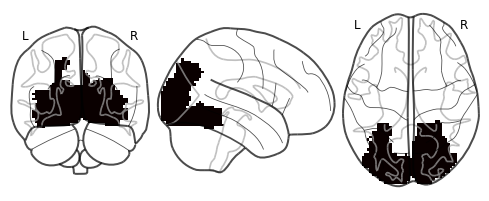

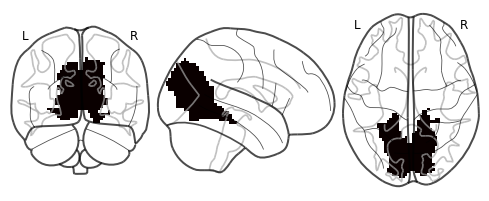

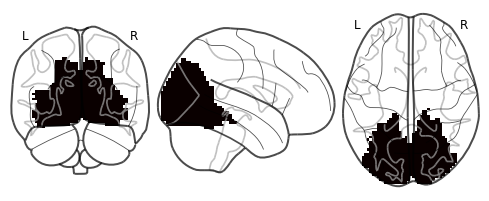

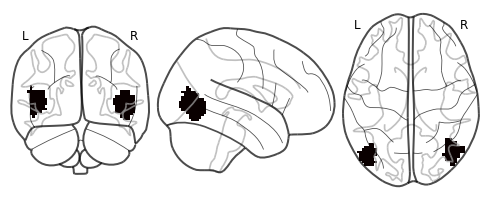

In [23]:
# nilearn.plotting.plot_glass_brain(roi_vis1)
# nilearn.plotting.plot_glass_brain(roi_vis2)
# nilearn.plotting.plot_glass_brain(roi_vis)
# nilearn.plotting.plot_glass_brain(roi_mt)

### calculating Pearson correlation
$\mu(t;ROI,mapping)$

In [25]:
mu_data = {}

for ii in id_list:
    for nn in nn_list:
        subj = ii + nn
        for region, img in roi_imgs.items():
            for i, rr in enumerate(run_list):
                pp = 'practiced' if i<3 else 'unpracticed'
                X = fast_masking(roi=img, img=data[subj, rr])
                mu_data[subj, region, pp, rr] = np.mean(X, axis=1)
            print(subj, region, end='\r')

In [26]:
## check non-96 trial data
set([len(v) for v in mu_data.values()])

{96}

In [24]:
scores_pearson(mu_data=mu_data, rois=roi_names, pickle_name='scores_pearson_visual-dmn')

### Load the pickle

In [16]:
dpkl = show_pkl_list(word='pearson')
dpkl

name identity
0  20210112_scores_pearson_visual-dmn.pkl        a
1  20210113_scores_pearson_visual-dmn.pkl        a
2  20210114_scores_pearson_visual-dmn.pkl        b

In [17]:
with open(dpkl.loc[2,'name'],"rb") as fr:
    scores = pickle.load(file=fr)

In [18]:
rois = sorted(list(set(np.concatenate([r for _, _, r in scores.keys()]))))
rois

['Core_PCC_l',
 'Core_PCC_r',
 'Core_aMPFC_l',
 'Core_aMPFC_r',
 'FuG_L_3_2',
 'FuG_R_3_2',
 'LOcC_L_2_1',
 'LOcC_L_2_2',
 'LOcC_L_4_1',
 'LOcC_L_4_3',
 'LOcC_L_4_4',
 'LOcC_R_2_1',
 'LOcC_R_4_1',
 'LOcC_R_4_3',
 'LOcC_R_4_4',
 'MTLsub_HF_l',
 'MTLsub_HF_r',
 'MTLsub_PHC_l',
 'MTLsub_PHC_r',
 'MTLsub_Rsp_l',
 'MTLsub_Rsp_r',
 'MTLsub_pIPL_l',
 'MTLsub_pIPL_r',
 'MTLsub_vMPFC',
 'MVOcC_L_5_1',
 'MVOcC_L_5_2',
 'MVOcC_L_5_3',
 'MVOcC_L_5_4',
 'MVOcC_L_5_5',
 'MVOcC_R_5_1',
 'MVOcC_R_5_2',
 'MVOcC_R_5_3',
 'MVOcC_R_5_4',
 'MVOcC_R_5_5',
 'PCun_L_4_3',
 'PCun_R_4_3',
 'PhG_L_6_6',
 'PhG_R_6_6',
 'dMsub_LTC_l',
 'dMsub_LTC_r',
 'dMsub_TPJ_l',
 'dMsub_TPJ_r',
 'dMsub_TempP_l_temp',
 'dMsub_TempP_r_temp',
 'dMsub_dMPFC']

### Build and display a correlation matrix

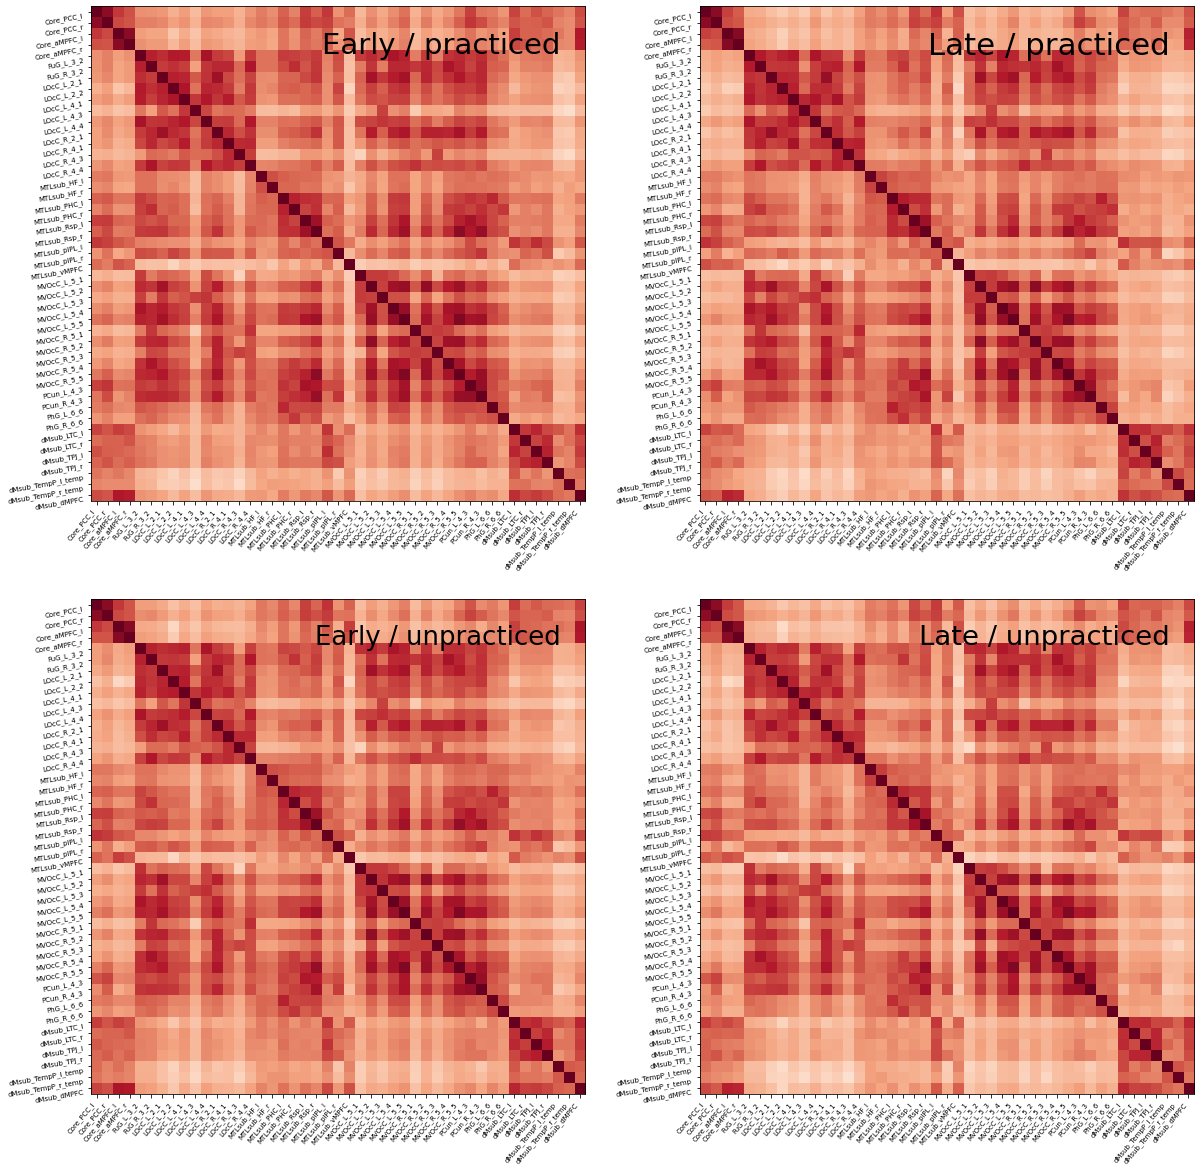

In [21]:
_, axes = plt.subplots(2,2,figsize=(20,20))
axes = np.concatenate(axes)

# subj = random.sample(range(30),k=1)[0]
# print('subj : GA%s'%nn_list[subj])
cnt = 0
for mapping in ['practiced', 'unpracticed']:
    for stage in ['Early', 'Late']:
        corr_mat = np.ones((len(rois),len(rois)))
        for i, ff in enumerate(rois):
            for j, tt in enumerate(rois[(i+1):]):
                corr_mat[i,j+i+1] = np.mean(scores[stage,mapping,(*sorted((ff,tt)),)])
#                 corr_mat[i,j+i+1] = scores[stage,mapping,(*sorted((ff,tt)),)][subj]
                corr_mat[j+i+1,i] = corr_mat[i,j+i+1]
        nplt.plot_matrix(corr_mat, labels=rois
                         , colorbar=False, auto_fit=True
                         , vmax=1., vmin=-1., axes=axes[cnt]
                         , title="%s / %s"%(stage,mapping)
                        )
        cnt += 1

### GB-GA

In [22]:
comb = [] ## ROI combinations
for key in scores.keys():
    comb.append(key[2])
comb = list(set(comb)) ## remove duplicate values

del_score = {}
for pp in ['practiced','unpracticed']:
    for from_roi, to_roi in comb:
        del_score[pp,(from_roi,to_roi)] = scores['Late',pp,(from_roi, to_roi)] - scores['Early',pp,(from_roi, to_roi)]

### load improvement in success rate (= GB-GA) from a text file

In [23]:
del_RR = np.loadtxt("RewardRate_improvement.txt", delimiter='\n')
del_RR

array([0.41741898, 0.36008102, 0.34666667, 0.41271991, 0.21287037,
       0.47524306, 0.34554398, 0.329375  , 0.54519676, 0.4193287 ,
       0.21936343, 0.31761574, 0.26476852, 0.5390162 , 0.16408565,
       0.52605324, 0.2922338 , 0.2971412 , 0.47497685, 0.150625  ,
       0.22175926, 0.16570602, 0.68708333, 0.40221065, 0.37399306,
       0.41167824, 0.52989583, 0.47359954, 0.41353009, 0.44251157])

### Plot data and a linear regression model fit

In [24]:
roi_vis = roi_names[:25]
roi_vis

['FuG_L_3_2',
 'FuG_R_3_2',
 'PhG_L_6_6',
 'PhG_R_6_6',
 'PCun_L_4_3',
 'PCun_R_4_3',
 'MVOcC_L_5_1',
 'MVOcC_R_5_1',
 'MVOcC_L_5_2',
 'MVOcC_R_5_2',
 'MVOcC_L_5_3',
 'MVOcC_R_5_3',
 'MVOcC_L_5_4',
 'MVOcC_R_5_4',
 'MVOcC_L_5_5',
 'MVOcC_R_5_5',
 'LOcC_L_4_1',
 'LOcC_R_4_1',
 'LOcC_L_4_3',
 'LOcC_R_4_3',
 'LOcC_L_4_4',
 'LOcC_R_4_4',
 'LOcC_L_2_1',
 'LOcC_R_2_1',
 'LOcC_L_2_2']

In [25]:
roi_dmn = roi_names[25:]
roi_dmn

['Core_PCC_l',
 'Core_PCC_r',
 'Core_aMPFC_l',
 'Core_aMPFC_r',
 'dMsub_LTC_l',
 'dMsub_LTC_r',
 'dMsub_TPJ_l',
 'dMsub_TPJ_r',
 'dMsub_TempP_l_temp',
 'dMsub_TempP_r_temp',
 'dMsub_dMPFC',
 'MTLsub_HF_l',
 'MTLsub_HF_r',
 'MTLsub_PHC_l',
 'MTLsub_PHC_r',
 'MTLsub_Rsp_l',
 'MTLsub_Rsp_r',
 'MTLsub_pIPL_l',
 'MTLsub_pIPL_r',
 'MTLsub_vMPFC']

In [26]:
def integration(rois, mapping):
    res = []
    
    for i, from_roi in enumerate(rois):
        for j, to_roi in enumerate(rois[(i+1):]):
            res.append(del_score[mapping, (*sorted((from_roi, to_roi)),)])

    return np.mean(res, axis=0)

In [27]:
def interaction(rois_1, rois_2, mapping):
    res = []
    
    for i, from_roi in enumerate(rois_1):
        for j, to_roi in enumerate(rois_2):
            res.append(del_score[mapping, (*sorted((from_roi, to_roi)),)])
            
    return np.mean(res, axis=0)

In [28]:
def draw_scatter(x, x_label):
    plt.figure(figsize=(5, 5))
    y = del_RR
    df = pd.DataFrame([y, x])
    df = df.transpose()
    df.columns = ['reward', 'x']
    sns.regplot(data=df, x='x', y='reward', ci=68)
    plt.ylabel('Reward GB-GA')
    plt.xlabel('%s GB-GA'%x_label)
    plt.title('r=%.4f (p=%.3f)' % (*scipy.stats.pearsonr(x=x, y=y),))
    #plt.xlim(-0.65, 0.65)
    plt.ylim(-0., 0.8)
    plt.show()

In [29]:
def draw_integration(rois, x_label):
    x = integration(rois, mapping='practiced')
    draw_scatter(x, x_label)
    
def draw_interaction(rois1, rois2, x_label):
    x = interaction(rois1, rois2, mapping='practiced')
    draw_scatter(x, x_label)

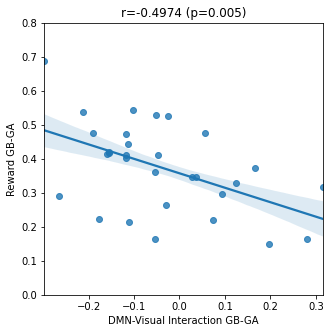

In [30]:
draw_interaction(rois1=roi_dmn, rois2=roi_vis, x_label='DMN-Visual Interaction')

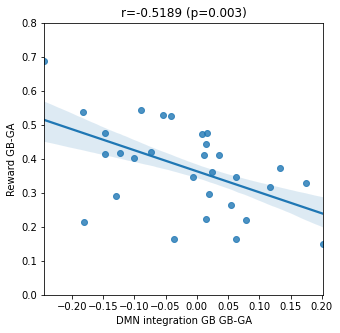

In [31]:
draw_integration(rois=roi_dmn, x_label='DMN integration GB')

### 